In [10]:
import pandas as pd         # Module Import
import numpy as np


car_df = pd.read_csv('cars.csv')        # 데이터 업로드
brand_df = pd.read_csv('brand.csv')


car_df['brand'] = car_df['title'].str.split().str[0]        # object를 숫자형으로 활용
brand_df['title'] = brand_df['title'].str.upper()
brand_df = brand_df.rename(columns={'title': 'brand'})

merged_df = car_df.merge(brand_df, on='brand', how='left')  # 데이터 결합

print(f"중복 제거 전: {len(merged_df)}행")
merged_df = merged_df.drop_duplicates()     # 모든 컬럼에 대해 중복된 행 제거
print(f"중복 제거 후: {len(merged_df)}행")

country_stats = merged_df.groupby('country')['Price'].agg(['mean', 'count']).reset_index() # 데이터 그룹화 및 요약

print("\n[국가별 평균 가격 및 매물 수]")    # 그룹화 결과 확인
pd.DataFrame(country_stats)


중복 제거 전: 3687행
중복 제거 후: 2859행

[국가별 평균 가격 및 매물 수]


,country,mean,count
0,Czech Republic,5116.723404,47
1,France,5059.234375,384
2,Germany,6365.846924,699
3,Italy,4424.259259,108
4,Japan,4690.919662,473
5,Malaysia,2226.666667,3
6,Romania,7439.571429,14
7,South Korea,6079.920863,139
8,Spain,5325.148936,47
9,Sweden,3983.414634,41


In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2859 entries, 0 to 3686
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2859 non-null   object 
 1   Price              2859 non-null   int64  
 2   Mileage(miles)     2859 non-null   int64  
 3   Registration_Year  2859 non-null   int64  
 4   Previous Owners    1876 non-null   float64
 5   Fuel type          2859 non-null   object 
 6   Body type          2859 non-null   object 
 7   Engine             2842 non-null   object 
 8   Gearbox            2859 non-null   object 
 9   Doors              2834 non-null   float64
 10  Seats              2824 non-null   float64
 11  Emission Class     2800 non-null   object 
 12  Service history    446 non-null    object 
 13  brand              2859 non-null   object 
 14  country            2859 non-null   object 
dtypes: float64(3), int64(3), object(9)
memory usage: 357.4+ KB


In [ ]:
from sklearn.preprocessing import RobustScaler  # RobustScaler import

# 수치형 데이터 전처리
merged_df['Engine'] = merged_df['Engine'].str.split('L').str[0]
merged_df['Engine'] = pd.to_numeric(merged_df['Engine'], errors='coerce')

# 분석에 사용할 수치형 컬럼 선정 및 결측치 제거
# merged_df.info()
numeric_features = ['Price', 'Mileage(miles)', 'Registration_Year', 'Previous Owners', 'Engine', 'Doors', 'Seats']
df_clean = merged_df.dropna(subset=numeric_features)

X = df_clean[numeric_features]

# RobustScaler 적용
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 스케일링된 데이터 확인
df_scaled = pd.DataFrame(X_scaled, columns=numeric_features)
print("\n[Robust Scaling 완료된 데이터 상위 5행]")
print(df_scaled.head())


[Robust Scaling 완료된 데이터 상위 5행]
      Price  Mileage(miles)  Registration_Year  Previous Owners    Engine  \
0  0.603538       -0.260655           0.666667              0.0 -0.285714   
1 -0.521332        0.131463          -0.666667              0.5 -0.571429   
2 -0.334027        0.305098          -0.333333              1.0 -0.285714   
3 -0.665973        0.890524          -0.833333              0.0  0.571429   
4 -0.562123        0.097678          -0.666667              1.0  0.000000   

   Doors  Seats  
0    0.0    0.0  
1   -2.0    0.0  
2   -2.0   -1.0  
3   -2.0   -1.0  
4    0.0    0.0  


[0.39014624 0.22215878 0.13380921 0.09935663 0.07968484 0.04969972
 0.02514457]

[누적 설명력 비율]
[0.39014624 0.61230503 0.74611423 0.84547087 0.92515571 0.97485543
 1.        ]

>> 전체 분산의 90% 이상을 설명하기 위한 주성분 개수: 5개


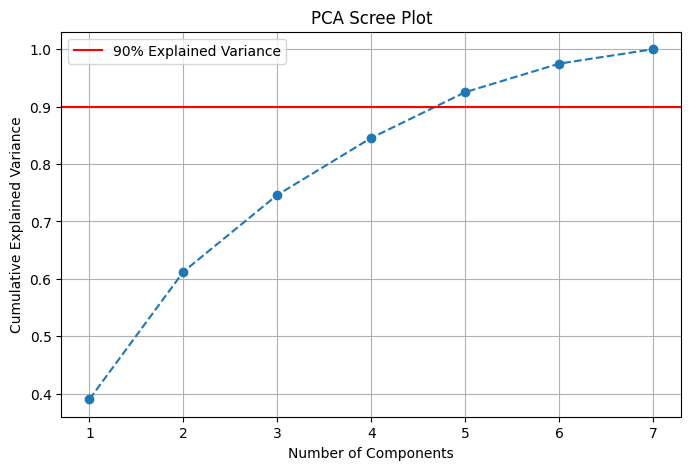


[최종 PCA 변환 데이터 (PC1 ~ PC5)]
        PC1       PC2       PC3       PC4       PC5
0  0.829457  0.414739 -0.192615  0.096512  0.424888
1 -1.272455 -0.979621 -0.734521 -0.208839  0.228723
2 -1.381064 -1.345408 -0.408412  0.041427  0.783409
3 -1.864900 -1.108107  0.340165 -0.538211 -0.321076
4 -1.051366  0.739741 -0.729947  0.665053  0.203727


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA 적용
pca = PCA()
pca.fit(X_scaled)

# 설명된 분산 비율 (전체 데이터 분산 중 어느 비율정도까지 설명하는 가?)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)   # 누적 설명력 비율 -> 주성분 개수를 더할 때 마다 설명력이 증가함

print("\n[누적 설명력 비율]")
print(cumulative_variance)

# 적절한 주성분 개수 결정 (90% 기준)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\n>> 전체 분산의 90% 이상을 설명하기 위한 주성분 개수: {n_components_90}개")

# Plot 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='-', label='90% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.legend()
plt.grid()
plt.show()

# 최종 PCA 변환
pca_final = PCA(n_components=n_components_90)
X_pca = pca_final.fit_transform(X_scaled)

pca_columns = [f'PC{i+1}' for i in range(n_components_90)]
df_pca_result = pd.DataFrame(X_pca, columns=pca_columns)
print(f"\n[최종 PCA 변환 데이터 (PC1 ~ PC{n_components_90})]")
print(df_pca_result.head())